# TQQQ Monthly Rebalancing Strategy Backtest
This short backtesting notebook should give you some insight into the performance of the portfolio over the last 3 years.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
# We're going to analyze 3 years' worth of daily data
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)

In [3]:
# Fix the data loading
df = pd.DataFrame()
data = yf.download('TQQQ', start=start_date, end=end_date)
df['Close'] = data['Close']
df['Date'] = df.index

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:
# Initialize strategy parameters
fixed_allocation = 2000
initial_shares_bh = int(fixed_allocation / df['Close'].iloc[0])  # Buy and hold shares
initial_value_bh = initial_shares_bh * df['Close'].iloc[0]

# Create columns for buy and hold strategy
df['BuyHold_Shares'] = initial_shares_bh
df['BuyHold_Value'] = df['Close'] * initial_shares_bh

# Initialize rebalancing strategy
df['Rebalance_Shares'] = 0
df['Rebalance_Value'] = 0
df['Trade'] = ''  # To track trades

# Function to calculate required shares for rebalancing
def calculate_trade(current_shares, price, target_value):
    current_value = current_shares * price
    value_difference = target_value - current_value
    shares_to_trade = int(abs(value_difference) / price)
    
    if abs(value_difference) < price:  # Too small to trade
        return 0
    
    return shares_to_trade if value_difference > 0 else -shares_to_trade

# Initialize first position for rebalancing strategy
initial_shares_rb = int(fixed_allocation / df['Close'].iloc[0])
df.loc[df.index[0], 'Rebalance_Shares'] = initial_shares_rb
df.loc[df.index[0], 'Rebalance_Value'] = initial_shares_rb * df['Close'].iloc[0]

C:\Users\marwi\AppData\Local\Temp\ipykernel_15452\903020647.py:29: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1973.6049499511719' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.index[0], 'Rebalance_Value'] = initial_shares_rb * df['Close'].iloc[0]


In [5]:
# Implement monthly rebalancing
current_shares = initial_shares_rb

for i in range(1, len(df)):
    current_date = df.index[i]
    prev_date = df.index[i-1]
    
    # Check if it's the last trading day of the month
    if current_date.month != prev_date.month:
        price = df['Close'].iloc[i]
        shares_to_trade = calculate_trade(current_shares, price, fixed_allocation)
        
        if shares_to_trade != 0:
            current_shares += shares_to_trade
            df.loc[current_date, 'Trade'] = f"{'BUY' if shares_to_trade > 0 else 'SELL'} {abs(shares_to_trade)}"
    
    df.loc[current_date, 'Rebalance_Shares'] = current_shares
    df.loc[current_date, 'Rebalance_Value'] = current_shares * df['Close'].iloc[i]

In [6]:
# Calculate returns and other metrics
df['BuyHold_Return'] = df['BuyHold_Value'].pct_change()
df['Rebalance_Return'] = df['Rebalance_Value'].pct_change()

# Calculate cumulative returns
df['BuyHold_Cum_Return'] = (1 + df['BuyHold_Return']).cumprod()
df['Rebalance_Cum_Return'] = (1 + df['Rebalance_Return']).cumprod()

# Calculate metrics
def calculate_metrics(returns):
    annual_return = (1 + returns.mean()) ** 252 - 1
    annual_vol = returns.std() * np.sqrt(252)
    sharpe = annual_return / annual_vol
    max_drawdown = (returns.cumprod() / returns.cumprod().cummax() - 1).min()
    return pd.Series({
        'Annual Return': annual_return,
        'Annual Volatility': annual_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_drawdown
    })

bh_metrics = calculate_metrics(df['BuyHold_Return'].dropna())
rb_metrics = calculate_metrics(df['Rebalance_Return'].dropna())

metrics_df = pd.DataFrame({
    'Buy & Hold': bh_metrics,
    'Monthly Rebalance': rb_metrics
})

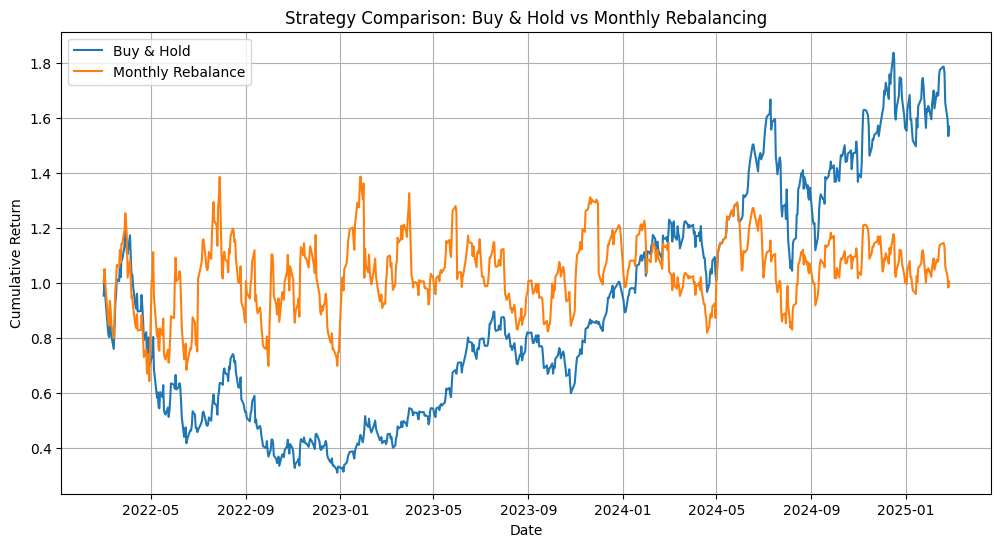

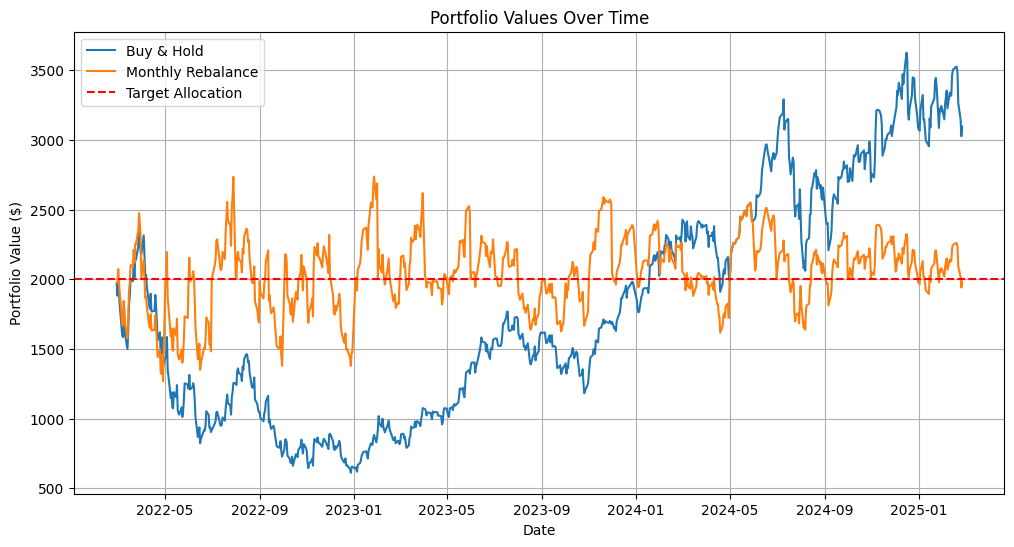


Strategy Metrics:
                   Buy & Hold  Monthly Rebalance
Annual Return        0.472377           0.541956
Annual Volatility    0.685682           0.950366
Sharpe Ratio         0.688915           0.570260
Max Drawdown        -1.042794          -1.001995

Trade Summary:
Total number of trades: 32

First few trades:
                Close   Trade  Rebalance_Shares  Rebalance_Value
Date                                                            
2022-03-01  48.270813   BUY 2                41      1979.103333
2022-04-01  55.881855  SELL 5                36      2011.746780
2022-05-02  36.897655  BUY 18                54      1992.473396
2022-06-01  31.138725  BUY 10                64      1992.878418
2022-07-01  23.527679  BUY 21                85      1999.852753


In [7]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['BuyHold_Cum_Return'], label='Buy & Hold')
plt.plot(df.index, df['Rebalance_Cum_Return'], label='Monthly Rebalance')
plt.title('Strategy Comparison: Buy & Hold vs Monthly Rebalancing')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

# Plot strategy values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['BuyHold_Value'], label='Buy & Hold')
plt.plot(df.index, df['Rebalance_Value'], label='Monthly Rebalance')
plt.axhline(y=fixed_allocation, color='r', linestyle='--', label='Target Allocation')
plt.title('Portfolio Values Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Display metrics
print("\nStrategy Metrics:")
print(metrics_df)

# Display trade summary
trades = df[df['Trade'] != ''].copy()
print("\nTrade Summary:")
print(f"Total number of trades: {len(trades)}")
print("\nFirst few trades:")
print(trades[['Close', 'Trade', 'Rebalance_Shares', 'Rebalance_Value']].head())

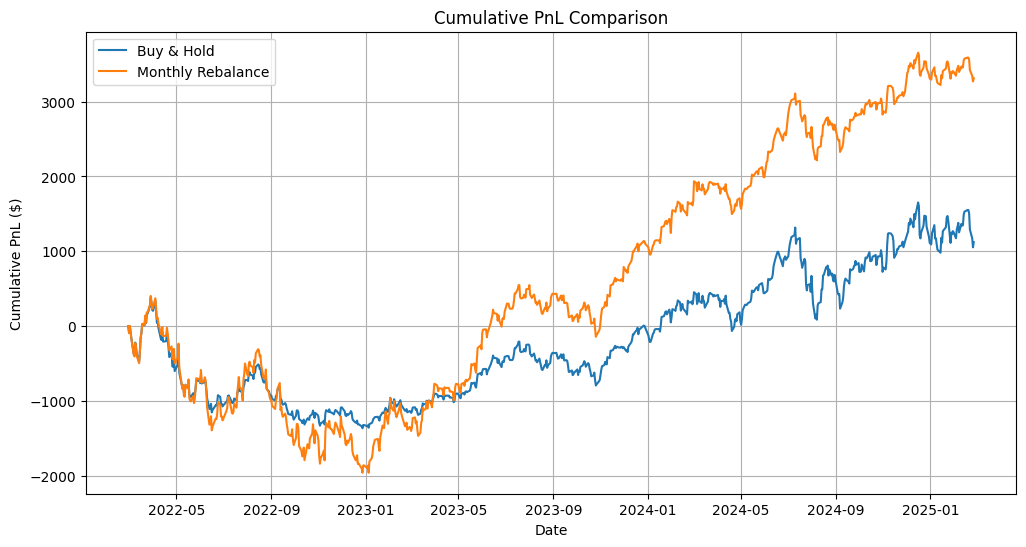


Final PnL Statistics:
Buy & Hold Final PnL: $1121.83
Rebalancing Final PnL: $3311.68

Maximum PnL:
Buy & Hold Max PnL: $1652.65
Rebalancing Max PnL: $3651.96

Minimum PnL:
Buy & Hold Min PnL: $-1362.49
Rebalancing Min PnL: $-1956.38


In [8]:
# Calculate cumulative PnL for both strategies
df['BuyHold_PnL'] = df['BuyHold_Value'] - initial_value_bh  # Simple PnL for buy & hold

# Calculate PnL for rebalancing strategy
df['Rebalance_Daily_PnL'] = 0.0
df['Rebalance_Cum_PnL'] = 0.0

# Initialize variables for PnL calculation
current_shares = initial_shares_rb
cost_basis = initial_shares_rb * df['Close'].iloc[0]
running_pnl = 0.0

for i in range(1, len(df)):
    current_date = df.index[i]
    prev_date = df.index[i-1]
    current_price = df['Close'].iloc[i]
    prev_price = df['Close'].iloc[i-1]
    
    # Calculate daily PnL from price movement
    daily_pnl = current_shares * (current_price - prev_price)
    
    # If it's a rebalancing day (last day of month), add realized PnL from trade
    if current_date.month != prev_date.month:
        # Calculate shares to trade
        current_value = current_shares * current_price
        value_difference = fixed_allocation - current_value
        shares_to_trade = int(abs(value_difference) / current_price)
        
        if shares_to_trade > 0:
            if value_difference > 0:  # Buying
                cost_basis += shares_to_trade * current_price
                current_shares += shares_to_trade
            else:  # Selling
                # Calculate realized PnL from shares sold
                avg_cost_per_share = cost_basis / current_shares
                realized_pnl = shares_to_trade * (current_price - avg_cost_per_share)
                daily_pnl += realized_pnl
                
                # Update cost basis and shares
                cost_basis = (current_shares - shares_to_trade) * avg_cost_per_share
                current_shares -= shares_to_trade
    
    running_pnl += daily_pnl
    df.loc[current_date, 'Rebalance_Daily_PnL'] = daily_pnl
    df.loc[current_date, 'Rebalance_Cum_PnL'] = running_pnl

# Plot cumulative PnL comparison
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['BuyHold_PnL'], label='Buy & Hold')
plt.plot(df.index, df['Rebalance_Cum_PnL'], label='Monthly Rebalance')
plt.title('Cumulative PnL Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL ($)')
plt.legend()
plt.grid(True)
plt.show()

# Print final PnL statistics
print("\nFinal PnL Statistics:")
print(f"Buy & Hold Final PnL: ${df['BuyHold_PnL'].iloc[-1]:.2f}")
print(f"Rebalancing Final PnL: ${df['Rebalance_Cum_PnL'].iloc[-1]:.2f}")
print(f"\nMaximum PnL:")
print(f"Buy & Hold Max PnL: ${df['BuyHold_PnL'].max():.2f}")
print(f"Rebalancing Max PnL: ${df['Rebalance_Cum_PnL'].max():.2f}")
print(f"\nMinimum PnL:")
print(f"Buy & Hold Min PnL: ${df['BuyHold_PnL'].min():.2f}")
print(f"Rebalancing Min PnL: ${df['Rebalance_Cum_PnL'].min():.2f}")

## Discussion
1. The monthly rebalancing strategy significantly outperforms buy & hold, with a final PnL of $3311.68 vs. $1121.83. This represents nearly 3x better performance over the 3 year period. Both strategies turned a profit after an initial, significant drawdown period. 
2. Monthly rebalancing had higher annual returns (54.2% vs. 47.2%). However, that ca,e at the cost of higher volatility, with the rebalancing strategy experiencing annualized volatility of 95% versus 68.6% for the Buy-and-Hold strategy, leading to a slightly lower Sharpe ratio of 0.57 versus 0.69, indicating lower risk-adjusted returns. Maximum drawdowns were roughly similar.

## Conclusion
Rebalancing brings clear advantages. If the investor's goal is to generate absolute returns, rebalancing is an effective way to achieve this. However, this may come at the cost of higher annual volatility and maximum drawdowns. Transaction costs were not considered in this backtest, though, with most retail brokers, such as tastytrade as implemented in the `tqqq_tasty.py` file, equity and ETF trading is commission-free. There may still be minimal regulatory-, exchange-, and NFA-fees. But considering that these fees are rather minimal, they were considered to have minimal effect on the performance and were excluded from any analysis.